# Part 1: EEG Preprocessing Pipeline
## Import All Libraries

In [1]:
import mne # Library for all EEG analysis.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs # ICA (Independent Component Analysis) for artifact removal.
import pandas as pd # lets us work with data in tables, like Excel.
import numpy as np # library for all numerical calculations in Python.
import scipy.io as sio # specific tool we need to read the .mat files.
import os # lets us work with files and folders.
import matplotlib.pyplot as plt # library for making plots.
# show plots directly inside the notebook.
%matplotlib inline 

## Setup Paths and Load Subject Info

In [2]:
# Define path


base_path = r"E:\Personal Project\Recognizing Mood Disorder Using EEG\EEG Data" # main folder where all data is.
subject_info_filename = "subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx"

subject_info_path = os.path.join(base_path, subject_info_filename)
output_folder_name = "filtered_EEG_data" # Ceate a folder for Filtered EEG Data.
output_path = os.path.join(base_path, output_folder_name) # Join the base path and the new folder name.


# create output folder

# check if the folder already exists.
if not os.path.exists(output_path):
    # If it does NOT exist, create it.
    os.makedirs(output_path)
    print(f"Created output directory: {output_path}")
else:
    # If it already exists, just print a message.
    print(f"Output directory already exists: {output_path}")


# load subject info

print(f"\nLoading subject info from: {subject_info_path}")
try:
    subject_info_df = pd.read_excel(
        subject_info_path,
        dtype={'subject id': str}
    )
    
    print("Successfully loaded subject info:")
    print(subject_info_df.head())

except Exception as e:
    # If the 'try' block fails, this code will run.
    print(f"--- ERROR loading Excel file: {e} ---")

Output directory already exists: E:\Personal Project\Recognizing Mood Disorder Using EEG\EEG Data\filtered_EEG_data

Loading subject info from: E:\Personal Project\Recognizing Mood Disorder Using EEG\EEG Data\subjects_information_EEG_128channels_resting_lanzhou_2015.xlsx
Successfully loaded subject info:
  subject id type  age gender  education（years）  PHQ-9  CTQ-SF  LES  SSRS  \
0   02010002  MDD   18      F                12     23      77 -143    31   
1   02010004  MDD   25      F                19     12      53  -44    38   
2   02010005  MDD   20      M                16     19      49   -3    28   
3   02010006  MDD   42      M                16     16      59  -30    40   
4   02010008  MDD   42      M                12     17      66  -71    44   

   GAD-7  PSQI  Unnamed: 11                              Unnamed: 12  
0     18    12          NaN                             abbreviation  
1     13    11          NaN          MDD = Major Depressive Disorder  
2     11     5    

Define Raw Data Loading Function

## Define Raw Data Loading Function

This cell defines our "tool" function for loading the raw .mat files. We need this special function because our files are messy and not standardized. This code automatically finds the EEG data (even if the name is different) and fixes its shape if it's "flipped" or has an extra 129th channel. Most importantly, it converts the signal's units from microvolts (µV) to Volts (V) using * 1e-6, which MNE requires. Finally, it applies a 1Hz filter to remove the slow "drifts" we saw, which gets the data ready for the next cleaning step (ICA).

In [15]:
def load_mat_file_as_raw(mat_file_path):
    """
    This is a docstring: it explains what the function does.
    It loads a .mat file, dynamically finds the EEG data and sampling rate,
    and creates an MNE Raw object.
    """
    
    # Load the .mat file
    
    mat_contents = sio.loadmat(mat_file_path)
    
    # Find the sampling rate

    try:
        sfreq = mat_contents['samplingRate'][0][0]
    except KeyError:
        print("     > WARNING: 'samplingRate' key not found. Defaulting to 250 Hz.")
        sfreq = 250
    except Exception as e:
        print(f"    > WARNING: Could not read 'samplingRate' ({e}). Defaulting to 250 Hz.")
        sfreq = 250

    # Find the main EEG data key
   
    eeg_data_key = None
    
    # This all are standard keys in .mat files that are *not* the data.
    ignore_keys = ['__header__', '__version__', '__globals__', 'samplingrate', 'impedances_0', 'din_1']
    
    for key in mat_contents.keys():
        if key.lower() not in ignore_keys:
            eeg_data_key = key
            break

    # If looped and found no data key, raise an error.
    if not eeg_data_key:
        raise Exception(f"Could not find the main data key. Keys are: {mat_contents.keys()}")

    # Extract the EEG data (the numbers) using the key which just found
    eeg_data = mat_contents[eeg_data_key]
            
    # Get the standard 128-channel channel locations ('montage')

    montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
    
    # Get the official list of 128 channel names from the montage
    ch_names = montage.ch_names
    
    # Check and Fix the data shape (rows vs columns)
    n_channels = len(ch_names)  # This will be 128
    
    # MNE *requires* data to be in the shape (n_channels, n_samples)
    # For example: (128, 75000)
    
    if eeg_data.shape[0] == n_channels:
        pass 
    
    elif eeg_data.shape[1] == n_channels:
        eeg_data = eeg_data.T  
    
    elif eeg_data.shape[0] == n_channels + 1:
        print("     > Note: Data has 129 channels. Dropping the last one (reference).")
        eeg_data = eeg_data[:128, :]  
    
    elif eeg_data.shape[1] == n_channels + 1:
        print("     > Note: Data has 129 channels. Transposing and dropping the last one.")
        eeg_data = eeg_data.T           
        eeg_data = eeg_data[:128, :] 
    
    else:
        # If none of these match, I don't know what to do.
        raise Exception(f"Data shape ({eeg_data.shape}) does not match 128 or 129 channels.")
        
    # Create the MNE 'Info' object
    
    # It tells MNE the channel names, sampling rate, and channel type (all 'eeg').
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    
    # Create the MNE 'RawArray' object
    
    # multiply by 1e-6 because the .mat file data is in microvolts (uV), but MNE requires Volts (V).
    
    raw = mne.io.RawArray(eeg_data * 1e-6, info, verbose='WARNING')
    
    # Apply initial filter and montage
    
    # apply a 1Hz high-pass filter before ICA. This removes slow signal drifts and makes the ICA algorithm work much better. 
    # n_jobs=-1 tells it to use all my CPU cores to run faster.
    
    raw.filter(l_freq=1.0, h_freq=None, verbose='WARNING', n_jobs=-1)
    
    # Tell the Raw object where the channels are located on the head on_missing='ignore' prevents errors if the montage has channels that are not in our data.
    raw.set_montage(montage, on_missing='ignore')
        
    # 10. Return the loaded and filtered Raw object
    return raw

print("Function 'load_mat_file_as_raw' defined successfully.")

Function 'load_mat_file_as_raw' defined successfully.


## Inspect Channel Locations (3D Montage)

Total channels in this montage: 128
First 10 channel names: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10']
Last 10 channel names: ['E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128']


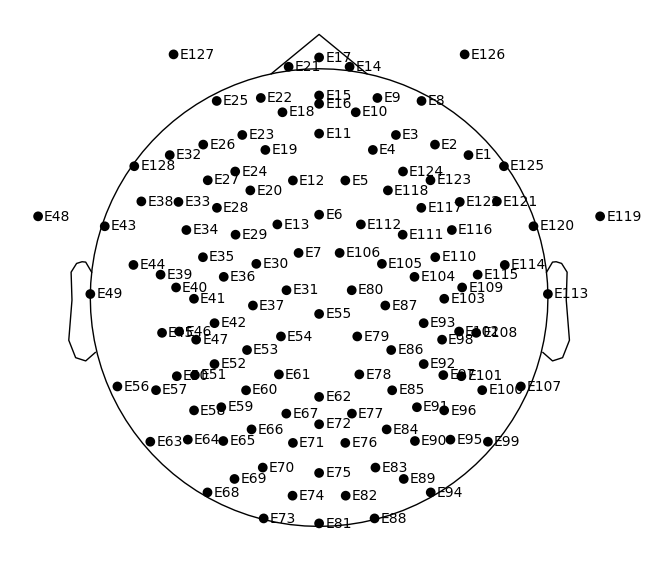

In [4]:
# create the montage

montage = mne.channels.make_standard_montage('GSN-HydroCel-128') # Creating the 'GSN-HydroCel-128' montage object

# print channel name

print(f"Total channels in this montage: {len(montage.ch_names)}") # The .ch_names attribute is a list of all 128 channel names


print("First 10 channel names:", montage.ch_names[:10])
print("Last 10 channel names:", montage.ch_names[-10:])


# plot channel location

montage.plot()
plt.show()

## Inspect Data - "Before" Preprocessing (Raw)

Loading first subject: 02010002 (Label: MDD)
Loading file: E:\Personal Project\Recognizing Mood Disorder Using EEG\EEG Data\02010002rest 20150416 1017..mat
Plotting 10 seconds of raw, unfiltered data...
Using matplotlib as 2D backend.


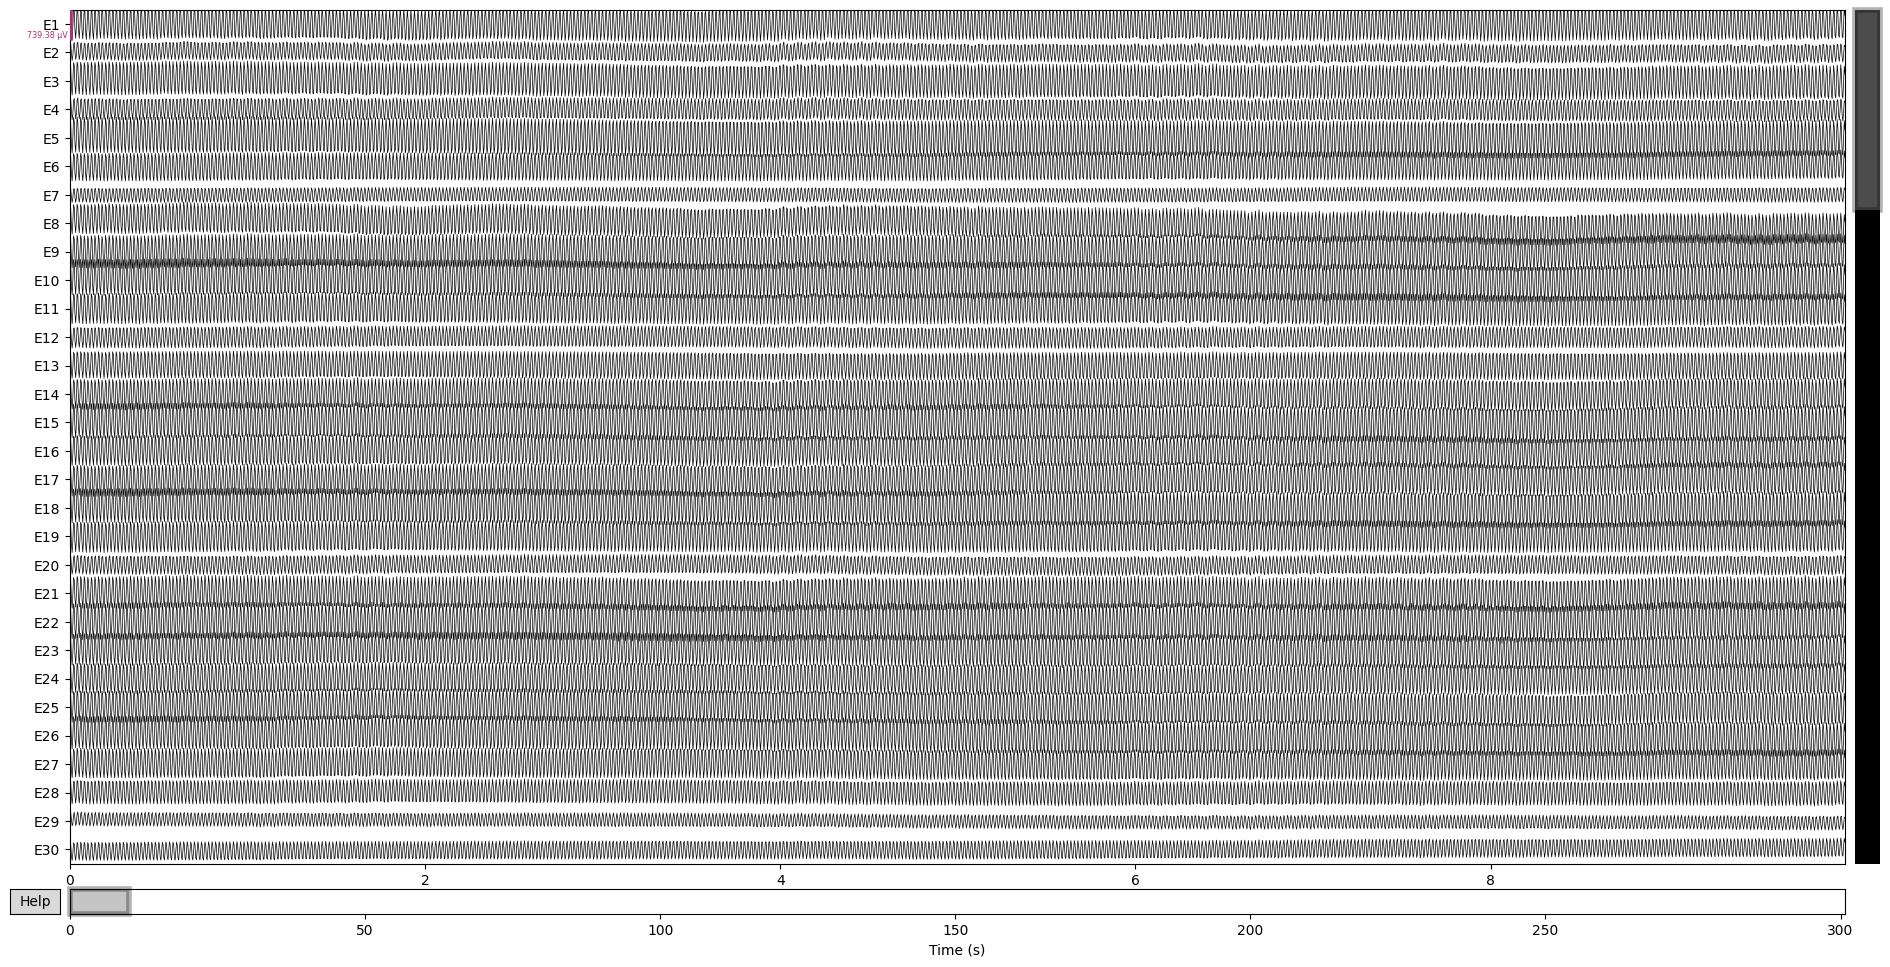

In [6]:
try:
    first_subject_row = subject_info_df.iloc[0]
    subject_id = first_subject_row['subject id'].strip()
    subject_label = first_subject_row['type']
    print(f"Loading first subject: {subject_id} (Label: {subject_label})")

    # Find the .mat file for this subject
    all_items_in_folder = os.listdir(base_path)
    data_file_name = None
    for item_name in all_items_in_folder:
        if item_name.startswith(subject_id) and item_name.lower().endswith(('.mat', '..mat')):
            data_file_name = item_name
            break
    
    if data_file_name:
        # If we found the file, create the full path
        eeg_file_path = os.path.join(base_path, data_file_name)
        
        # Load the data WITHOUT filtering 
        print(f"Loading file: {eeg_file_path}")
        mat_contents = sio.loadmat(eeg_file_path)
        
        # Get sampling rate (defaulting to 250 if not found)
        try: sfreq = mat_contents['samplingRate'][0][0]
        except Exception: sfreq = 250
        
        # Get data key
        eeg_data_key = None
        ignore_keys = ['__header__', '__version__', '__globals__', 'samplingrate', 'impedances_0', 'din_1']
        for key in mat_contents.keys():
            if key.lower() not in ignore_keys:
                eeg_data_key = key
                break
        eeg_data = mat_contents[eeg_data_key]

        # Get montage and fix shape
        montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
        ch_names = montage.ch_names
        n_channels = len(ch_names)
        
        if eeg_data.shape[0] == n_channels: pass
        elif eeg_data.shape[1] == n_channels: eeg_data = eeg_data.T
        elif eeg_data.shape[0] == n_channels + 1: eeg_data = eeg_data[:128, :]
        elif eeg_data.shape[1] == n_channels + 1: eeg_data = eeg_data.T; eeg_data = eeg_data[:128, :]
        else: raise Exception(f"Data shape ({eeg_data.shape}) does not match 128 or 129 channels.")
        
        # Create the Raw object (NO FILTERING)
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        raw_unprocessed = mne.io.RawArray(eeg_data * 1e-6, info, verbose='WARNING')
        raw_unprocessed.set_montage(montage, on_missing='ignore')

        # plot
        print("Plotting 10 seconds of raw, unfiltered data...")
        # scalings='auto' will try to find a good scale to show the noisy data
        raw_unprocessed.plot(
            duration=10, 
            n_channels=30, 
            title=f"RAW Data - Subject {subject_id} (NO preprocessing)",
            scalings='auto' 
        )
        plt.show()

    else:
        print(f"Could not find .mat file for first subject {subject_id}")
        
except Exception as e:
    print(f"--- ERROR loading or plotting raw file: {e}")

## Define Full Preprocessing Function

In [16]:
def preprocess_eeg_subject(raw, subject_id):
    """
    This function takes one subject's Raw data and applies all
    preprocessing steps: ICA, Filtering, Epoching, and Referencing.
    """
    
    print(f"    > Starting ICA for {subject_id}...")
    
    # Setup and Fit ICA
    # find 20 strongest signal.
    # random_state=42 ensures we get the same result every time.
    ica = ICA(n_components=20, method='fastica', random_state=42)
    
    # ICA works best on data filtered from 1-40 Hz.
    # make a temporary copy of the raw data just for this.
    raw_for_ica = raw.copy().filter(l_freq=1.0, h_freq=40.0, n_jobs=-1, verbose='WARNING')
    
    # This is the "training" step. MNE 'fits' the ICA model
    # to the data to find the 20 components. This can take a few seconds.
    ica.fit(raw_for_ica)

    # Find and remove artifacts
    # use channel 'E25' (near the eye) as a guide.
    eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='E25', verbose='WARNING')
    
    if eog_indices:
        # If the list of bad components is not empty...
        print(f"    > Found {len(eog_indices)} EOG (blink) components to remove: {eog_indices}")
        # ...add them to the 'exclude' list.
        ica.exclude = eog_indices
    else:
        # If the list is empty, no blinks were found.
        print(f"    > No EOG components automatically found.")

    # apply ICA

    raw_cleaned = ica.apply(raw.copy(), verbose='WARNING')

    #  apply filter

    raw_cleaned.filter(l_freq=1.0, h_freq=40.0, n_jobs=-1, verbose='WARNING')

    # chop data in epochs
    
    epochs = mne.make_fixed_length_epochs(
        raw_cleaned, 
        duration=2.0, 
        overlap=0.0, 
        preload=True,
        verbose='WARNING'
    )
    
    # Re-reference to average
    # set the reference for all channels to be the AVERAGE of all 128 channels. This makes the signal much more stable and removes noise.
    
    epochs.set_eeg_reference('average', projection=True, verbose='WARNING')
    epochs.apply_proj(verbose='WARNING')
    
    # Return the final, clean, epoched data

    return epochs, ica

print("Function 'preprocess_eeg_subject' defined successfully.")

Function 'preprocess_eeg_subject' defined successfully.


## Inspect Data - "After" Preprocessing (Clean)

Running full preprocessing pipeline for 02010002...
     > Note: Data has 129 channels. Dropping the last one (reference).
    > Starting ICA for 02010002...
Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.0s.
    > No EOG components automatically found.

Plotting 5 cleaned epochs for Subject 02010002...
Compare this to the 'RAW' plot. The big blinks and slow drifts should be gone.


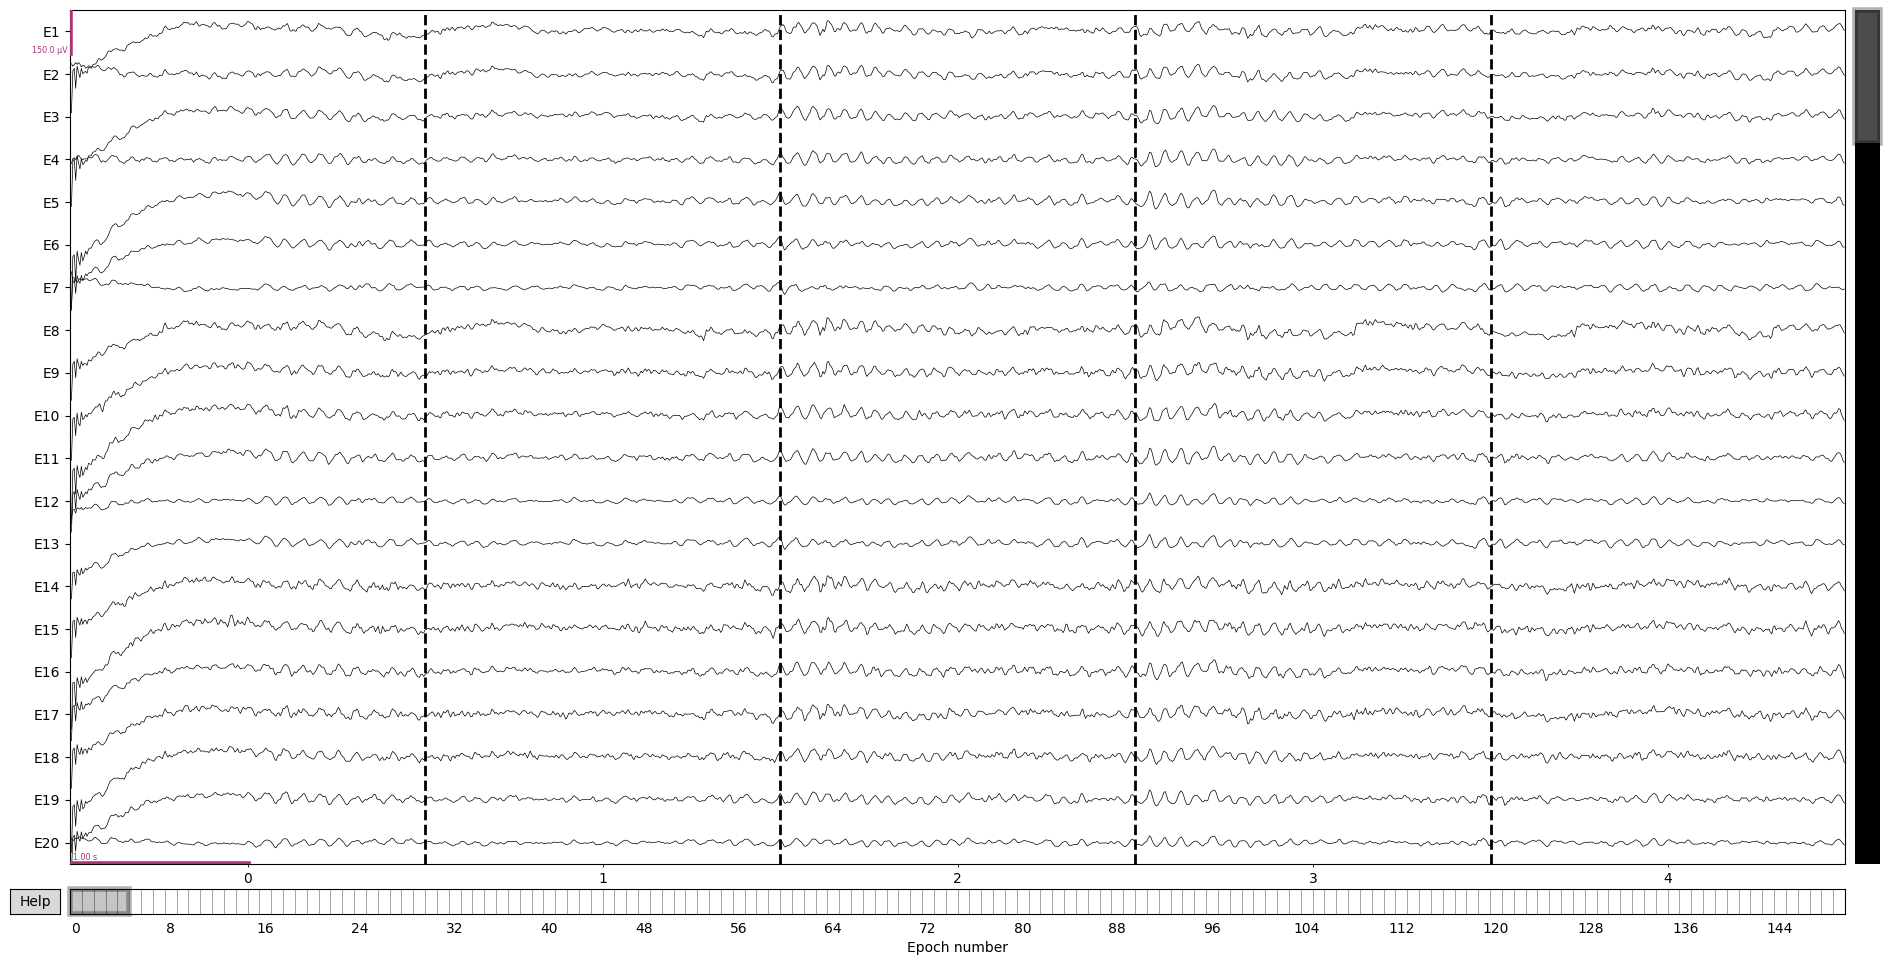

In [9]:
try:
    # Get the first subject
    first_subject_row = subject_info_df.iloc[0]
    subject_id = first_subject_row['subject id'].strip()
    subject_label = first_subject_row['type']

    # Find the .mat file 
    all_items_in_folder = os.listdir(base_path)
    data_file_name = None
    for item_name in all_items_in_folder:
        if item_name.startswith(subject_id) and item_name.lower().endswith(('.mat', '..mat')):
            data_file_name = item_name
            break
            
    if data_file_name:
        
        print(f"Running full preprocessing pipeline for {subject_id}...")
        
        # Create the full file path
        eeg_file_path = os.path.join(base_path, data_file_name)
        
    

        raw = load_mat_file_as_raw(eeg_file_path)
        
    
        # runs ICA, filtering, epoching, and referencing.
        subject_epochs, subject_ica = preprocess_eeg_subject(raw, subject_id)
        
        # plot the cleaned epochs
        print(f"\nPlotting 5 cleaned epochs for Subject {subject_id}...")
        print("Compare this to the 'RAW' plot. The big blinks and slow drifts should be gone.")
        
        # .plot() is the MNE function to show the epochs
        subject_epochs.plot(
            n_epochs=5, 
            n_channels=20,
            title=f"Final Cleaned Epochs (Subject: {subject_id})",
            # set a fixed scale (75 microvolts) so the plot is stable
            scalings=dict(eeg=75e-6) 
        )
        plt.show()
        
    else:
        print(f"Could not find .mat file for first subject {subject_id}")
except Exception as e:
    print(f"--- ERROR processing or plotting cleaned file: {e}")

## Visualization - How ICA Removes Blinks

     > Note: Data has 129 channels. Dropping the last one (reference).
    > Starting ICA for 02010002...
Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 5.6s.
    > No EOG components automatically found.

Plotting 1: ICA Components (the 'Head Maps')
Look for the component outlined in RED. This is the blink artifact.


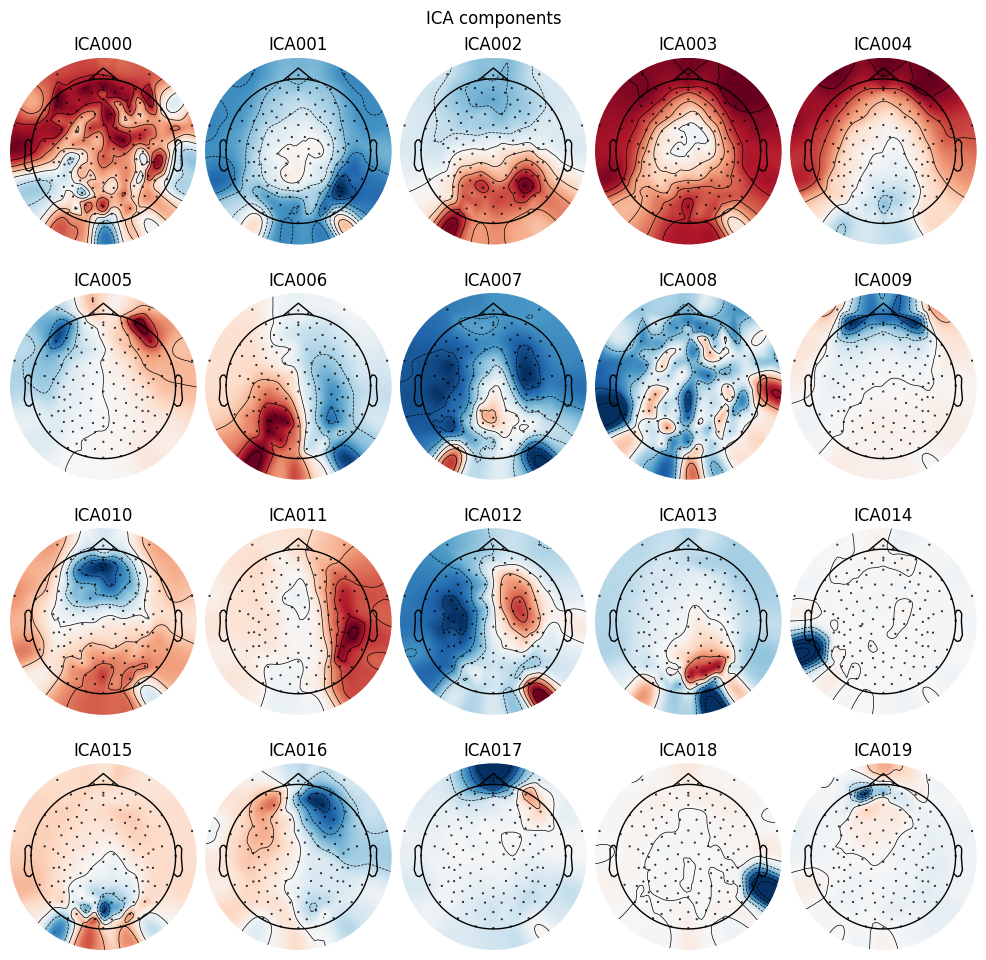

In [17]:
try:
    first_subject_row = subject_info_df.iloc[0]
    subject_id = first_subject_row['subject id'].strip()
    
    all_items_in_folder = os.listdir(base_path)
    data_file_name = None
    for item_name in all_items_in_folder:
        if item_name.startswith(subject_id) and item_name.lower().endswith(('.mat', '..mat')):
            data_file_name = item_name
            break
            
    if data_file_name:
        eeg_file_path = os.path.join(base_path, data_file_name)
        
        # Load the raw file
        raw = load_mat_file_as_raw(eeg_file_path)
        
        # Run the full pipeline 
        subject_epochs, subject_ica = preprocess_eeg_subject(raw, subject_id)
        
        
        # Plot ICA componets
        print("\nPlotting 1: ICA Components (the 'Head Maps')")
        print("Look for the component outlined in RED. This is the blink artifact.")
        
        # Plot shows the "head map" for all 20 components.
        # The red blotch at the front (like 'ICA000' or 'ICA001') is the classic pattern for an eye blink. Automatic detector found it and outlined it in red.
        subject_ica.plot_components()
        plt.show()
        
    else:
        print(f"Could not find .mat file for first subject {subject_id}")
except Exception as e:
    print(f"--- ERROR in Cell 8: {e}")

## Run Pipeline on All Subjects and Save Files

In [18]:
# Get a list of all filenames in data folder
all_items_in_folder = os.listdir(base_path)

# A counter to see how many subjects successfully processed
subjects_processed = 0

# Loop through each row in the Excel file
# .iterrows() gives us the 'index' (row number) and 'row' (the data)
for index, row in subject_info_df.iterrows():
    
    # Get the subject ID
    subject_id = row['subject id'].strip()
    # Get the label (e.g., "MDD")
    subject_label = row['type']
    
    print(f"\n--- Processing Subject: {subject_id} ({subject_label}) ---")

    # --- Find the matching .mat file --- 
    data_file_name = None
    # Loop through all files we found in the folder
    for item_name in all_items_in_folder:
        # If the filename starts with the subject's ID and ends with .mat...
        if item_name.startswith(subject_id) and item_name.lower().endswith(('.mat', '..mat')):
            data_file_name = item_name  # ...we found our file!
            break # Stop this inner loop and move on
            
    # --- Process the file --- 
    if data_file_name:
        # We found a file, so we'll try to process it.
        # We use 'try...except' so that if one subject fails
        # (e.g., a corrupt file), the whole script doesn't crash.
        try:
            # Create the full path to the .mat file
            eeg_file_path = os.path.join(base_path, data_file_name)
            
            # Call function for load the file
            raw = load_mat_file_as_raw(eeg_file_path)
            
            # Call function for clean the data
            epochs, ica = preprocess_eeg_subject(raw, subject_id)
            
            # Save the cleaned data
            
            # Create a descriptive filename for the clean file
            # e.g., "02010002_label_MDD-epo.fif"
            # because .fif is the standard MNE ending for epoched data.
            output_filename = f"{subject_id}_label_{subject_label}-epo.fif"
            
            # Create the full path to save the file in output folder
            
            output_filepath = os.path.join(output_path, output_filename)
            
            # Save the 'epochs' object to the file
            # overwrite=True means it will replace an old file if it exists
            epochs.save(output_filepath, overwrite=True, verbose='WARNING')
            
            print(f"  > SUCCESS: Saved clean data to {output_filename}")
            subjects_processed += 1 # Add one to our success counter

        except Exception as e:
            # If anything in the 'try' block fails, this code will run
            print(f"    --- ERROR --- ")
            print(f"    Could not process subject {subject_id}. Error: {e}")
            print(f"    Skipping this subject.")
    else:
        # If 'data_file_name' is still None, we never found a .mat file
        print(f"    --- WARNING: No .mat file found for {subject_id}. Skipping.")

print(f"\n\n--- ALL PROCESSING COMPLETE ---")
print(f"Successfully processed and saved {subjects_processed} / {len(subject_info_df)} subjects.")
print(f"find all the clean .fif files in: {output_path}")


--- Processing Subject: 02010002 (MDD) ---
     > Note: Data has 129 channels. Dropping the last one (reference).
    > Starting ICA for 02010002...
Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.1s.
    > No EOG components automatically found.
  > SUCCESS: Saved clean data to 02010002_label_MDD-epo.fif

--- Processing Subject: 02010004 (MDD) ---
     > Note: Data has 129 channels. Dropping the last one (reference).
    > Starting ICA for 02010004...
Fitting ICA to data using 128 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.5s.
    > Found 1 EOG (blink) components to remove: [np.int64(0)]
  > SUCCESS: Saved clean data to 02010004_label_MDD-epo.fif

--- Processing Subject: 02010005 (MDD) ---
     > Note: Data has 129 channels. Dropping the last one (reference).
    > Starting ICA for 02010005...
Fitting ICA to data using 128 channels (ple